# Image Conversion Pipeline
- Taken from `https://github.com/thongonary/LCDJets/blob/master/Transform.py`
- For each row, produce an image from a matrix of features 

In [7]:
features = sqlContext.read.format("parquet").load("file:/Users/vk/data/ML_MP_JR/ttbar_lepFilter_13TeV/*.parquet")

In [2]:
features.show()

+--------------------+--------------------+
|           hfeatures|           lfeatures|
+--------------------+--------------------+
|[51.0764198303222...|[WrappedArray(44....|
|[469.079421997070...|[WrappedArray(67....|
|[222.012012481689...|[WrappedArray(189...|
|[84.7050094604492...|[WrappedArray(36....|
|[118.823188781738...|[WrappedArray(31....|
|[612.161636352539...|[WrappedArray(60....|
|[259.445648193359...|[WrappedArray(386...|
|[379.874328613281...|[WrappedArray(76....|
|[235.096134185791...|[WrappedArray(44....|
|[299.053157806396...|[WrappedArray(65....|
|[164.111095428466...|[WrappedArray(51....|
|[94.1477622985839...|[WrappedArray(121...|
|[225.197017669677...|[WrappedArray(43....|
|[66.8187332153320...|[WrappedArray(292...|
|[179.064170837402...|[WrappedArray(705...|
|[134.533317565917...|[WrappedArray(70....|
|[746.370513916015...|[WrappedArray(319...|
|[892.570121765136...|[WrappedArray(53....|
|[473.942733764648...|[WrappedArray(48....|
|[192.498855590820...|[WrappedAr

## Step1 Build up the functionality
- various imports
- conversion function

In [3]:
import time
import numpy as np
from pyspark.sql import Row
import math
from skimage import draw 
import matplotlib 

import numpy as np
from scipy import misc
import time
import sys
import matplotlib
from skimage import draw 
import os
import matplotlib.pyplot as plt
import random

matplotlib.__version__

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


'2.1.0'

In [13]:
from pyspark.sql import Row

In [28]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]


# In[259]:

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print c_colors
print cc_colors
print cc_shapes

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([ 1.,  0.,  0.]), array([ 1.,  1.,  0.]), array([ 0.,  0.,  1.]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.,  0.,  0.])]
[4, 0, 3, 5, 5, 0]


In [33]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    plt.savefig('fig.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

def create3D(data):
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    return image


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    lmat = np.asarray(row.lfeatures, dtype=np.float64)
    hmat = np.asarray(row.hfeatures, dtype=np.float64)
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    return Row(image=reduced.tolist())

In [8]:
before = time.time()
images = features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 2 seconds


In [9]:
images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [44]:
test_images = images.take(10)

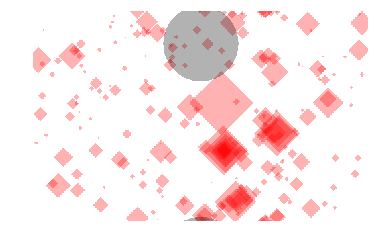

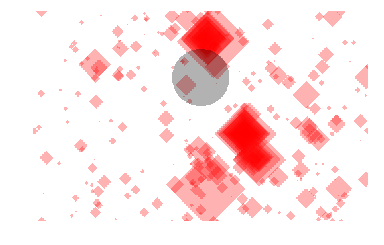

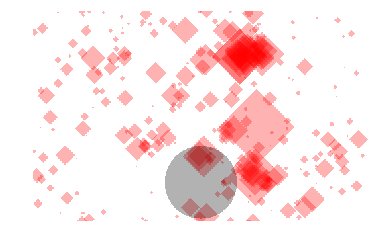

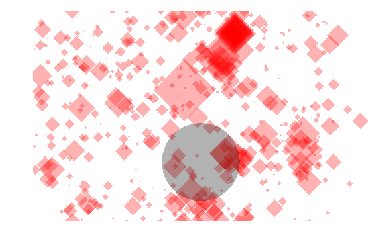

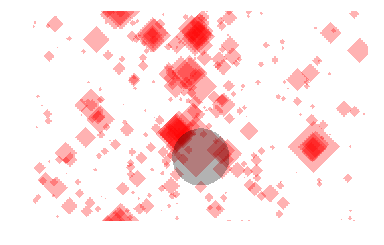

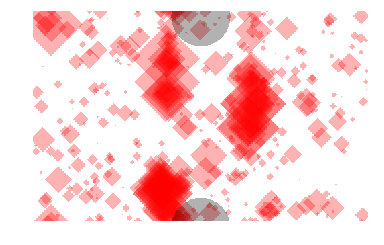

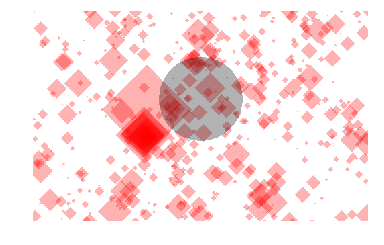

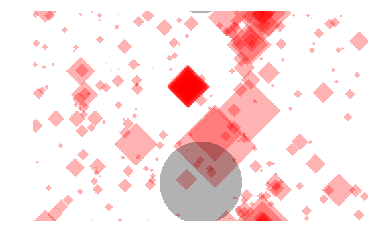

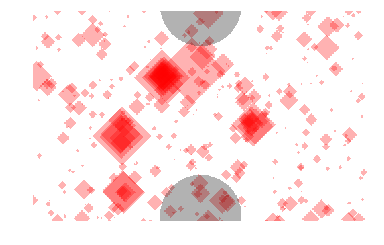

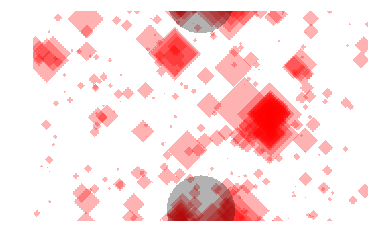

In [45]:
for x in test_images:
    data = np.asarray(x.image)
    img = create3D(data)
    showImage(img)